In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.graph_objects as go


In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account
import os

# Manually specify the path to your service account key
credentials_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "YOU NEED TO COPY PASTE YOUR CREDENTIALS PATH HERE")

# Explicitly load credentials from file
credentials = service_account.Credentials.from_service_account_file(credentials_path)

# Initialize BigQuery client with credentials
client = bigquery.Client(credentials=credentials)

# Example query
query = """
    with prep as (
select
  min(parse_date('%Y%m%d', event_date)) as date,
  user_pseudo_id,
  concat(user_pseudo_id,(select value.int_value from unnest(event_params) where key = 'ga_session_id')) as session_id,
  coalesce(array_agg((select value.string_value from unnest(event_params) where key = 'source') ignore nulls order by event_timestamp)[safe_offset(0)],'(direct)') as source,
  coalesce(array_agg((select value.string_value from unnest(event_params) where key = 'medium') ignore nulls order by event_timestamp)[safe_offset(0)],'(none)') as medium,
  coalesce(array_agg((select value.string_value from unnest(event_params) where key = 'campaign') ignore nulls order by event_timestamp)[safe_offset(0)],'(not set)') as campaign,
  max((select value.int_value from unnest(event_params) where event_name = 'session_start' and key = 'ga_session_number')) as session_number,
  max((select value.string_value from unnest(event_params) where key = 'session_engaged')) as session_engaged,
  max((select value.int_value from unnest(event_params) where key = 'engagement_time_msec')) as engagement_time_msec,
  count(event_name) as event_count,
  -- change event_name to the event(s) you want to count
  countif(event_name = 'click') as specific_event_count,
  -- change event_name to the conversion event(s) you want to count
  countif(event_name = 'purchase') as conversions,
  sum(ecommerce.purchase_revenue) as total_revenue
from
  `# YOU NEED TO COPY PASTE YOUR TABLE ID HERE`
where
  _table_suffix between '20220101' and format_date('%Y%m%d', date_sub(current_date(), interval 1 day))
group by
  user_pseudo_id,
  session_id)

select
  date,
  case 
    when source = '(direct)' and (medium in ('(not set)','(none)')) then 'Direct'
    when regexp_contains(campaign, 'cross-network') then 'Cross-network'
    when (regexp_contains(source,'alibaba|amazon|google shopping|shopify|etsy|ebay|stripe|walmart')
      or regexp_contains(campaign, '^(.*(([^a-df-z]|^)shop|shopping).*)$'))
      and regexp_contains(medium, '^(.*cp.*|ppc|paid.*)$') then 'Paid Shopping'
    when regexp_contains(source,'baidu|bing|duckduckgo|ecosia|google|yahoo|yandex')
      and regexp_contains(medium,'^(.*cp.*|ppc|paid.*)$') then 'Paid Search'
    when regexp_contains(source,'badoo|facebook|fb|instagram|linkedin|pinterest|tiktok|twitter|whatsapp')
      and regexp_contains(medium,'^(.*cp.*|ppc|paid.*)$') then 'Paid Social'
    when regexp_contains(source,'dailymotion|disneyplus|netflix|youtube|vimeo|twitch|vimeo|youtube')
      and regexp_contains(medium,'^(.*cp.*|ppc|paid.*)$') then 'Paid Video'
    when medium in ('display', 'banner', 'expandable', 'interstitial', 'cpm') then 'Display'
    when regexp_contains(source,'alibaba|amazon|google shopping|shopify|etsy|ebay|stripe|walmart')
      or regexp_contains(campaign, '^(.*(([^a-df-z]|^)shop|shopping).*)$') then 'Organic Shopping'
    when regexp_contains(source,'badoo|facebook|fb|instagram|linkedin|pinterest|tiktok|twitter|whatsapp')
      or medium in ('social','social-network','social-media','sm','social network','social media') then 'Organic Social'
    when regexp_contains(source,'dailymotion|disneyplus|netflix|youtube|vimeo|twitch|vimeo|youtube')
      or regexp_contains(medium,'^(.*video.*)$') then 'Organic Video'
    when regexp_contains(source,'baidu|bing|duckduckgo|ecosia|google|yahoo|yandex')
      or medium = 'organic' then 'Organic Search'
    when regexp_contains(source,'email|e-mail|e_mail|e mail')
      or regexp_contains(medium,'email|e-mail|e_mail|e mail') then 'Email'
    when medium = 'affiliate' then 'Affiliates'
    when medium = 'referral' then 'Referral'
    when medium = 'audio' then 'Audio'
    when medium = 'sms' then 'SMS'
    when medium like '%push'
      or regexp_contains(medium,'mobile|notification') then 'Mobile Push Notifications'
    else 'Unassigned'
  end as session_default_channel_group,
  --source as session_source,
  --medium as session_medium,
  --concat(source,' / ',medium) as session_source_medium,
  --campaign as session_campaign,
  count(distinct user_pseudo_id) as total_users,
  count(distinct case when engagement_time_msec > 0  or session_engaged = '1' then user_pseudo_id end) as active_users,
  count(distinct session_id) as sessions,
  count(distinct case when session_engaged = '1' then session_id end) as engaged_sessions,
  safe_divide(sum(engagement_time_msec/1000),count(distinct case when session_engaged = '1' then session_id end)) as average_engagement_time_seconds,
  safe_divide(count(distinct case when session_engaged = '1' then session_id end),count(distinct user_pseudo_id)) as engaged_sessions_per_user,
  safe_divide(count(distinct case when session_engaged = '1' then session_id end),count(distinct session_id)) as engagement_rate,
  safe_divide(sum(event_count),count(distinct session_id)) as events_per_session,
  sum(event_count) as total_event_count,
  sum(specific_event_count) as specific_event_count,
  sum(conversions) as conversions,
  safe_divide(sum(conversions),count(distinct session_id)) as session_conversion_rate,
  ifnull(sum(total_revenue),0) as total_revenue
from
  prep
group by
  date,
  session_default_channel_group
  --,session_source
  --,session_medium
  --,session_source_medium
  --,session_campaign
order by
  total_users desc
"""

# Run the query and print the results
query_job = client.query(query)
results = query_job.to_dataframe()

print(results)

/Users/martinguzman/environments/myenv-py311/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


            date session_default_channel_group  total_users  active_users  \
0     2022-08-11                        Direct         1916          1213   
1     2022-08-12                        Direct         1250           693   
2     2023-01-31                        Direct          987           684   
3     2022-08-15                        Direct          957           525   
4     2023-07-24                        Direct          931           711   
...          ...                           ...          ...           ...   
8025  2023-05-19                       Display            1             1   
8026  2024-05-06                    Unassigned            1             1   
8027  2023-07-18              Organic Shopping            1             1   
8028  2024-03-06                 Organic Video            1             0   
8029  2022-12-19              Organic Shopping            1             1   

      sessions  engaged_sessions  average_engagement_time_seconds  \
0     

In [3]:
df = results

In [4]:
df.head()

,date,session_default_channel_group,total_users,active_users,sessions,engaged_sessions,average_engagement_time_seconds,engaged_sessions_per_user,engagement_rate,events_per_session,total_event_count,specific_event_count,conversions,session_conversion_rate,total_revenue
0,2022-08-11,Direct,1916,1213,2767,1401,8.067630,0.731211,0.506325,4.631370,12815,38,0,0.0,0.0
1,2022-08-12,Direct,1250,693,1672,694,9.614297,0.555200,0.415072,4.526914,7569,39,0,0.0,0.0
2,2023-01-31,Direct,987,684,1349,715,22.968285,0.724417,0.530022,9.080059,12249,32,0,0.0,0.0
3,2022-08-15,Direct,957,525,1220,501,13.788212,0.523511,0.410656,4.872131,5944,78,0,0.0,0.0
4,2023-07-24,Direct,931,711,1026,570,26.670342,0.612245,0.555556,8.719298,8946,61,0,0.0,0.0


In [5]:
df = df.rename(columns={'session_default_channel_group': 'channel'})

In [6]:
df.columns

Index(['date', 'channel', 'total_users', 'active_users', 'sessions',
       'engaged_sessions', 'average_engagement_time_seconds',
       'engaged_sessions_per_user', 'engagement_rate', 'events_per_session',
       'total_event_count', 'specific_event_count', 'conversions',
       'session_conversion_rate', 'total_revenue'],
      dtype='object')

In [7]:
tsa = df[['date', 'channel', 'sessions', 'total_users', 'active_users']]

In [8]:
tsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8030 entries, 0 to 8029
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          8030 non-null   dbdate
 1   channel       8030 non-null   object
 2   sessions      8030 non-null   Int64 
 3   total_users   8030 non-null   Int64 
 4   active_users  8030 non-null   Int64 
dtypes: Int64(3), dbdate(1), object(1)
memory usage: 337.3+ KB


In [9]:
tsa.shape

(8030, 5)

In [10]:
tsa_analysis = tsa.groupby(['date', 'channel'], as_index=False).sum()

In [11]:
tsa_analysis.shape

(8030, 5)

In [12]:
#Filter the data for 'Organic Search' channel
organic_search_data = tsa_analysis[tsa_analysis['channel'] == 'Organic Search']

# Create the figure
fig = go.Figure()

# Add a line plot for total users
fig.add_trace(go.Scatter(
    x=organic_search_data.index,
    y=organic_search_data['total_users'],
    mode='lines+markers',  # Adds both lines and markers
    line=dict(color='royalblue', width=2),  # Custom line color and width
    marker=dict(size=8, color='orange', line=dict(width=1, color='DarkSlateGrey')),  # Custom markers
    name='Total Users'
))

# Add average line with annotation
fig.add_shape(
    type='line',
    x0=organic_search_data.index.min(),
    y0=organic_search_data['total_users'].mean(),
    x1=organic_search_data.index.max(),
    y1=organic_search_data['total_users'].mean(),
    line=dict(color='red', width=2, dash='dash'),
    name='Average Users'
)

fig.add_annotation(
    x=organic_search_data.index[int(len(organic_search_data) * 0.7)],
    y=organic_search_data['total_users'].mean(),
    text='Average Users',
    showarrow=False,
    font=dict(size=12, color='red')
)

# Update layout for a polished look
fig.update_layout(
    title='Daily Total Users from Organic Search',
    title_font=dict(size=20, color='darkslategray'),
    xaxis_title='Date',
    yaxis_title='Total Users',
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    xaxis=dict(showgrid=True, gridcolor='LightGrey'),
    yaxis=dict(showgrid=True, gridcolor='LightGrey'),
    font=dict(family="Arial", size=12),
    legend=dict(x=0.8, y=1.1),
    hovermode='x unified'  # Unified hover mode for better interactivity
)

# Show the interactive plot
fig.show()


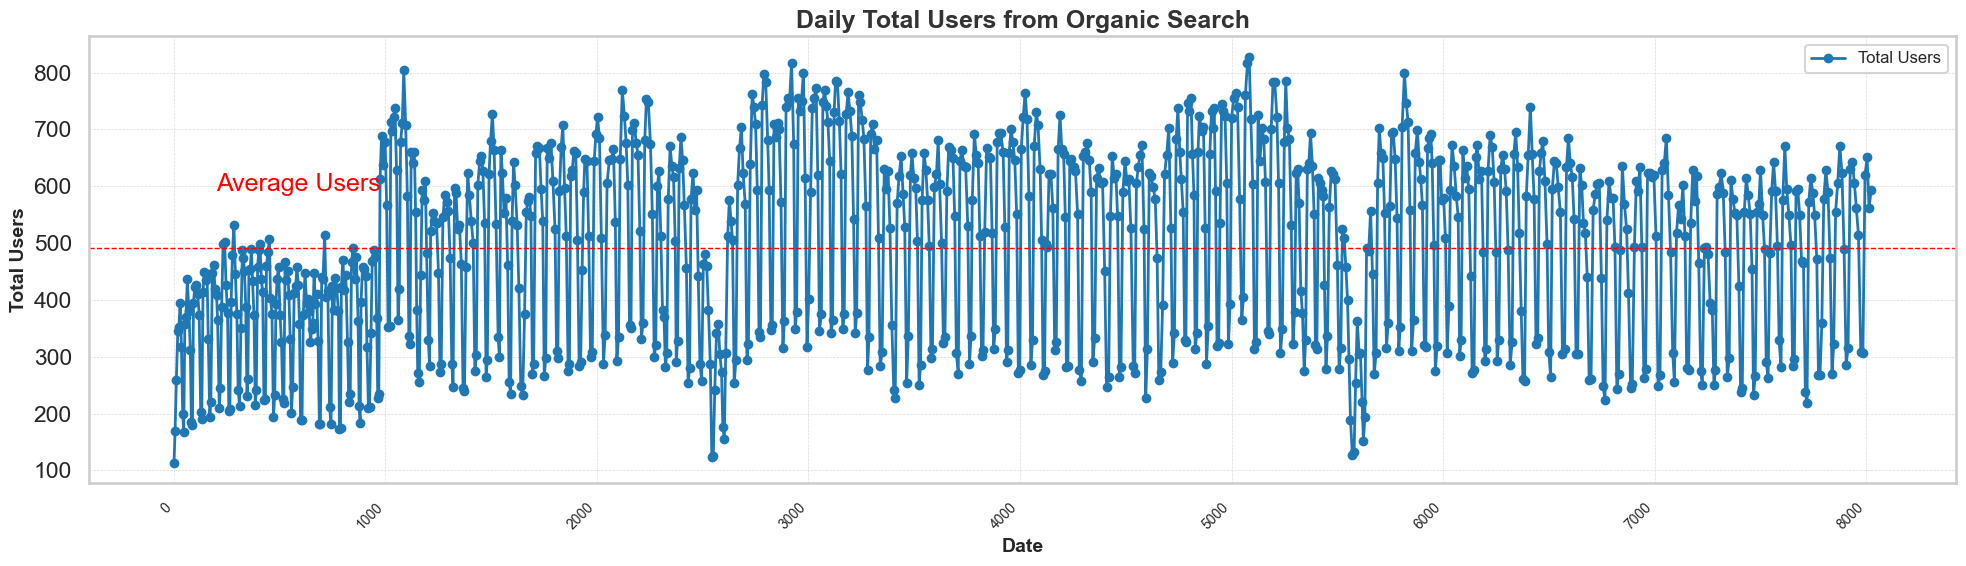

In [39]:


# Create the plot
plt.figure(figsize=(20, 6))

# Plot the data with enhancements
plt.plot(organic_search_data['total_users'], color='#1f77b4', linewidth=2, marker='o', markersize=6, linestyle='-', label='Total Users')

# Add titles and labels
plt.title('Daily Total Users from Organic Search', fontsize=18, fontweight='bold', color='#333')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Total Users', fontsize=14, fontweight='bold')

# Customize the grid
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend
plt.legend(loc='upper right', fontsize=12)

# Highlight important events or thresholds (Optional)
plt.axhline(y=organic_search_data['total_users'].mean(), color='red', linestyle='--', linewidth=1, label='Average Users')
plt.text(x=len(organic_search_data) * 0.2, y=organic_search_data['total_users'].mean() + 100, s='Average Users', color='red')

# Improve the x-axis with better formatting (Optional)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

<Axes: >

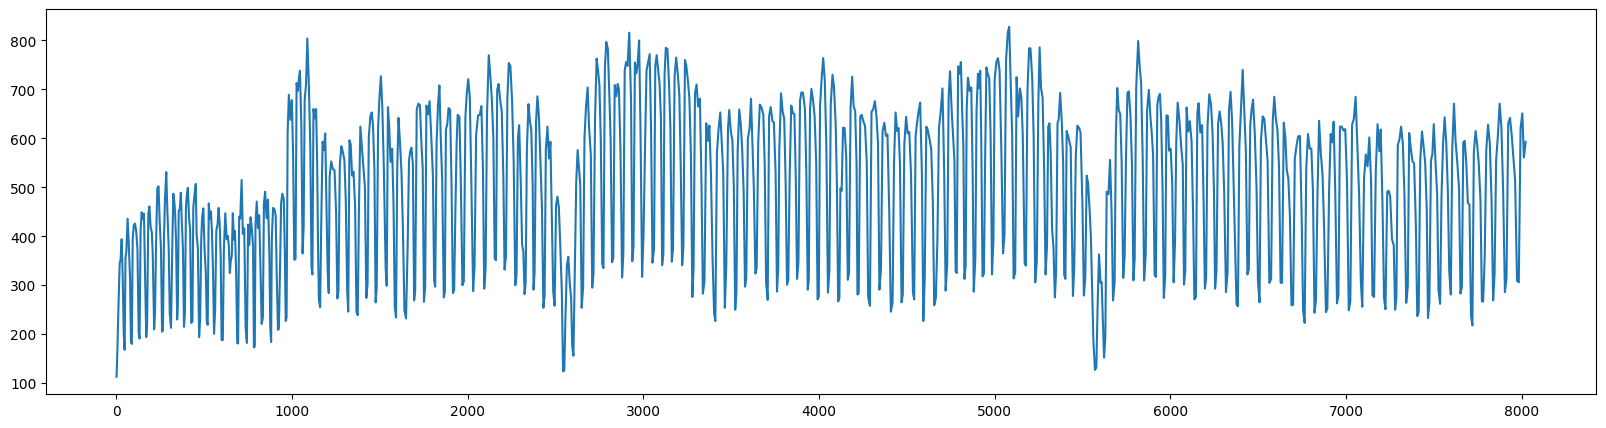

In [14]:
tsa_analysis[tsa_analysis['channel'] == 'Organic Search']['total_users'].plot(figsize=(20, 5))

In [15]:
organic_analysis = tsa_analysis[tsa_analysis['channel'] == 'Organic Search']

In [16]:
organic_analysis.set_index('date', inplace=True)

In [17]:
organic_analysis

,channel,sessions,total_users,active_users
date,,,,
2022-01-01,Organic Search,122,113,104
2022-01-02,Organic Search,186,170,151
2022-01-03,Organic Search,280,259,232
2022-01-04,Organic Search,387,346,311
2022-01-05,Organic Search,378,352,316
...,...,...,...,...
2024-09-22,Organic Search,319,306,283
2024-09-23,Organic Search,645,620,577
2024-09-24,Organic Search,680,651,609


In [18]:
organic_analysis = organic_analysis.asfreq('b')

In [19]:
organic_analysis

,channel,sessions,total_users,active_users
date,,,,
2022-01-03,Organic Search,280,259,232
2022-01-04,Organic Search,387,346,311
2022-01-05,Organic Search,378,352,316
2022-01-06,Organic Search,434,394,339
2022-01-07,Organic Search,338,317,279
...,...,...,...,...
2024-09-20,Organic Search,536,514,474
2024-09-23,Organic Search,645,620,577
2024-09-24,Organic Search,680,651,609


In [20]:
organic_search_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 8023
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1000 non-null   dbdate
 1   channel       1000 non-null   object
 2   sessions      1000 non-null   Int64 
 3   total_users   1000 non-null   Int64 
 4   active_users  1000 non-null   Int64 
dtypes: Int64(3), dbdate(1), object(1)
memory usage: 49.8+ KB


In [21]:
def plot_outliers(outliers, data, method="KNN",
                  haligment = "right",
                  valigment = 'bottom',
                  labels=False):
    ax = data.plot(alpha=0.6)

    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}',
                    horizontalaligment=haligment,
                    verticalaligment=valigment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')

    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.legend(['nyc taxi', 'outliers'])
    plt.show

<Axes: xlabel='total_users', ylabel='Count'>

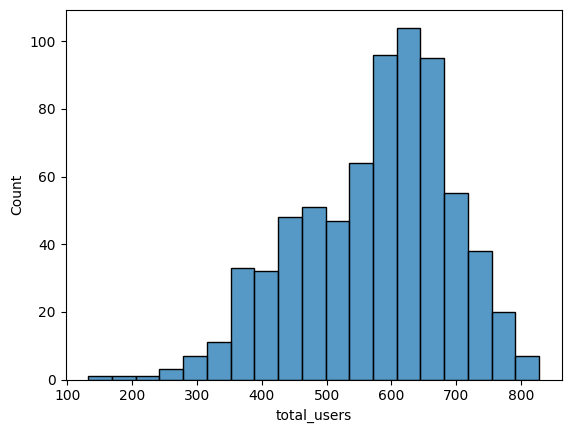

In [22]:
sns.histplot(organic_analysis['total_users'])

<Axes: xlabel='date'>

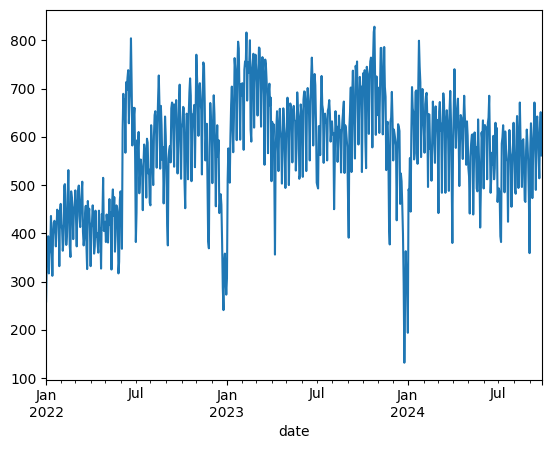

In [23]:

organic_analysis['total_users'].plot()


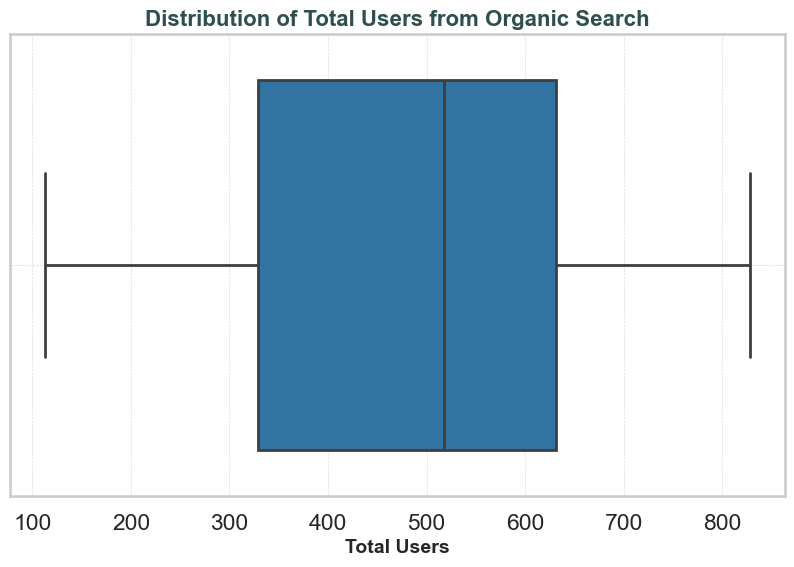

In [24]:

# Set the style and context for better aesthetics
sns.set_style('whitegrid')  # Use a white grid background
sns.set_context('talk')  # Adjust context to 'talk' for larger elements

# Create a larger figure
plt.figure(figsize=(10, 6))

# Plot the boxplot with customizations
sns.boxplot(x=organic_search_data['total_users'], color='#1f77b4', whis=1.5, fliersize=5, linewidth=2)

# Add a title and labels
plt.title('Distribution of Total Users from Organic Search', fontsize=16, fontweight='bold', color='darkslategray')
plt.xlabel('Total Users', fontsize=14, fontweight='bold')

# Customize the grid
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

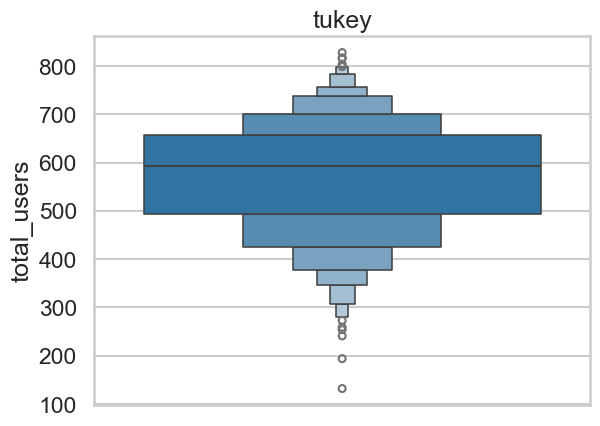

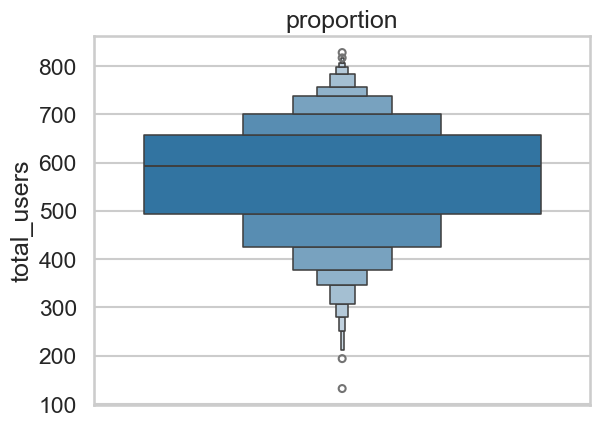

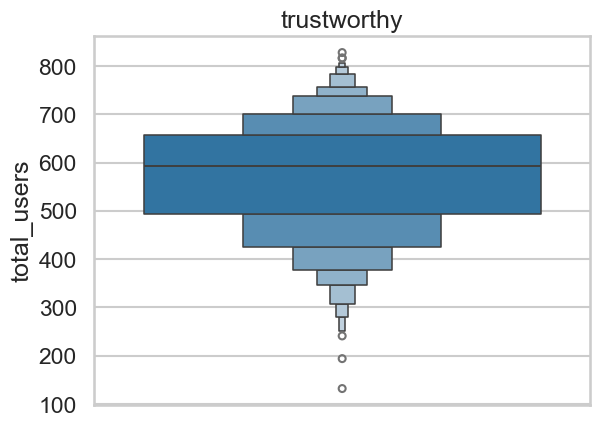

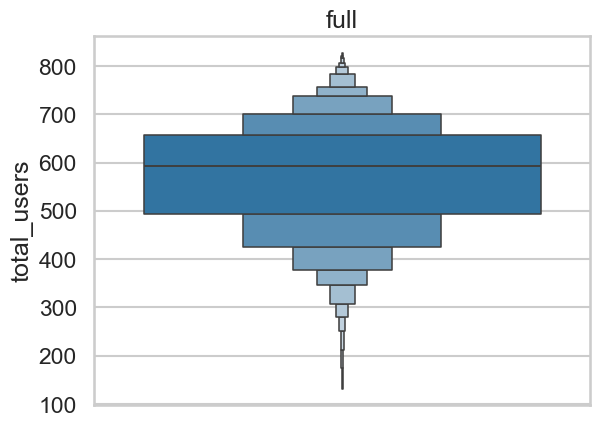

In [25]:
for k in ["tukey", 'proportion', 'trustworthy', 'full']:
    sns.boxenplot(organic_analysis['total_users'], k_depth=k)
    plt.title(k)
    plt.show()

In [26]:
percentiles = [0, 0.05, .10, .25, .5, .75, .90, 1]

In [27]:
organic_analysis['total_users'].describe(percentiles= percentiles)

count         714.0
mean     574.355742
std      116.130202
min           132.0
0%            132.0
5%           369.65
10%           409.3
25%           493.0
50%           593.5
75%           657.0
90%           712.7
100%          828.0
max           828.0
Name: total_users, dtype: Float64

In [28]:
percentiles = [0,5,10,25,50,75,90,95,100]

np.percentile(organic_analysis['total_users'], percentiles)

array([132.  , 369.65, 409.3 , 493.  , 593.5 , 657.  , 712.7 , 743.7 ,
       828.  ])

In [29]:
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    print(f'This is beautiful and this is the: {lower_fence}, {upper_fence}')
    outliers = data[(data < lower_fence) | (data > upper_fence)]

    if outliers.empty:
        print("No outliers were found")
    else:
        return print(f'These are: {outliers}')

In [120]:
def iqr_outliers_dos(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    print(f'This is are your lower fence: {lower_fence}, upper fence: {upper_fence}')
    
    outliers = data[(data < lower_fence) | (data > upper_fence)]

    if outliers.empty:
        print("No outliers were found")
    else:
        print(f'Outliers values: {outliers}')
        return outliers

In [30]:
outliers = iqr_outliers(organic_analysis['total_users'])

This is beautiful and this is the: 247.0, 903.0
These are: date
2022-12-26    241
2023-12-25    132
2024-01-01    194
Name: total_users, dtype: Int64


In [121]:
outliers_dos = iqr_outliers_dos(organic_analysis['total_users'])

This is are your lower fence: 247.0, upper fence: 903.0
Outliers values: 255    241
515    132
520    194
Name: total_users, dtype: Int64


In [ ]:
from prophet.diagnostics import cross_validation

# Perform cross-validation with an initial training period of 365 days,
# making predictions every 30 days, with a prediction horizon of 200 days
df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='200 days')

# Check the cross-validated predictions
df_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/13 [00:00<?, ?it/s]14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:00<00:00, 14.44it/s]14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:00<00:00, 15.38it/s]14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:00<00:00, 15.31it/s]14:57:36 - cmdstanpy - INFO - Chain [1] st

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-06,345.144157,280.426094,403.149897,505,2023-01-05
1,2023-01-09,453.010788,393.173980,516.387324,602,2023-01-05
2,2023-01-10,518.443918,454.896029,583.236832,667,2023-01-05
3,2023-01-11,529.205585,465.839642,589.133771,704,2023-01-05
4,2023-01-12,507.927304,451.745769,566.597303,623,2023-01-05


In [31]:
def zscore(df, degree=3):
    data = df.copy()
    data['zscore'] = (data - data.mean()) / data.std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]

    return outliers['total_users'], data

In [32]:
organic_analysis['zscore'] = (organic_analysis['total_users'] -
                              organic_analysis['total_users'].mean()) / organic_analysis['total_users'].std()

In [33]:
outliers = organic_analysis[(organic_analysis['zscore'] <= -2.5) | (organic_analysis['zscore'] >= 2.5)]

In [34]:
outliers

,channel,sessions,total_users,active_users,zscore
date,,,,,
2022-01-03,Organic Search,280,259,232,-2.715536
2022-12-26,Organic Search,256,241,214,-2.870534
2022-12-30,Organic Search,294,273,235,-2.594982
2023-12-25,Organic Search,144,132,117,-3.809136
2023-12-26,Organic Search,267,254,229,-2.758591
2024-01-01,Organic Search,206,194,173,-3.275253


In [35]:
def plot_m_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(20, 8))
    plt.plot(data, 'k^')
    plt.plot([0,n], [d,d], 'r--')
    plt.plot([0,n], [-d, -d], 'r--')

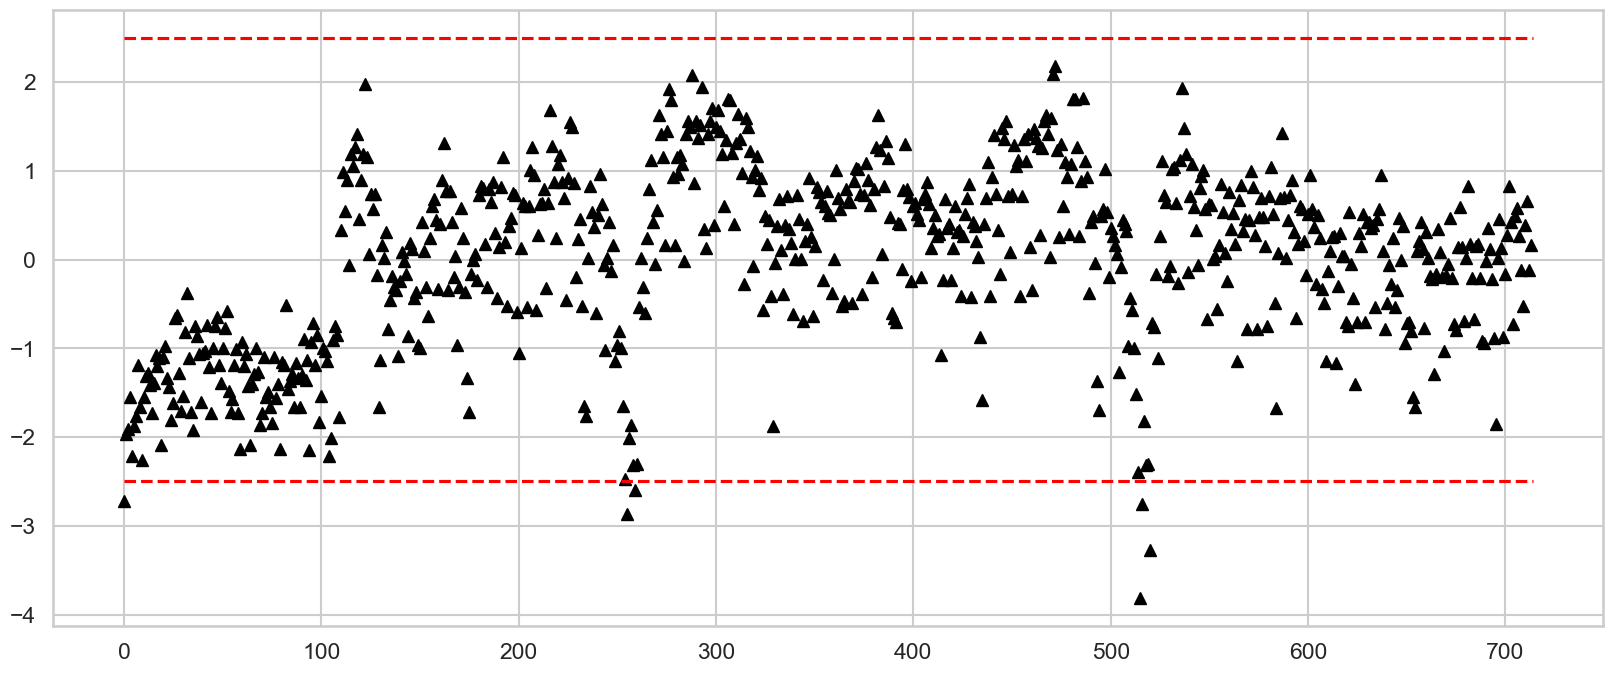

In [36]:
data = organic_analysis['zscore'].values
plot_m_zscore(data, d=2.5)

In [41]:
organic_analysis.head(20)

,channel,sessions,total_users,active_users,zscore
date,,,,,
2022-01-03,Organic Search,280,259,232,-2.715536
2022-01-04,Organic Search,387,346,311,-1.966377
2022-01-05,Organic Search,378,352,316,-1.914711
2022-01-06,Organic Search,434,394,339,-1.553048
2022-01-07,Organic Search,338,317,279,-2.216097
2022-01-10,Organic Search,392,357,315,-1.871656
2022-01-11,Organic Search,411,370,331,-1.759712
2022-01-12,Organic Search,500,436,385,-1.191385
2022-01-13,Organic Search,426,381,341,-1.664991


In [84]:
organic_analysis= organic_analysis.reset_index()

In [85]:
prophet_df = organic_analysis[['date', 'total_users']].rename(columns={'date': 'ds', 'total_users': 'y'})

In [86]:
prophet_df

,ds,y
0,2022-01-03,259
1,2022-01-04,346
2,2022-01-05,352
3,2022-01-06,394
4,2022-01-07,317
...,...,...
709,2024-09-20,514
710,2024-09-23,620
711,2024-09-24,651
712,2024-09-25,561


In [99]:
# Splitting the data into training and testing sets
train_size = int(len(prophet_df) * 0.9)
train_df = prophet_df.iloc[:-50]
test_df = prophet_df.tail(50)

print( len(test_df), len(train_df))


50 664


In [100]:
model = Prophet()


In [101]:
model.fit(train_df)

14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
future_dates = model.make_future_dataframe(periods=50)

In [103]:
forecast = model.predict(future_dates)

In [104]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-03,341.095428,123.257661,266.604220,341.095428,341.095428,-149.424182,-149.424182,-149.424182,12.069539,12.069539,12.069539,-161.493721,-161.493721,-161.493721,0.0,0.0,0.0,191.671246
1,2022-01-04,342.071128,184.062054,326.412785,342.071128,342.071128,-81.660897,-81.660897,-81.660897,62.644378,62.644378,62.644378,-144.305275,-144.305275,-144.305275,0.0,0.0,0.0,260.410231
2,2022-01-05,343.046828,199.682697,343.881608,343.046828,343.046828,-70.142048,-70.142048,-70.142048,55.933886,55.933886,55.933886,-126.075934,-126.075934,-126.075934,0.0,0.0,0.0,272.904781
3,2022-01-06,344.022529,192.611227,333.526020,344.022529,344.022529,-81.283670,-81.283670,-81.283670,25.813678,25.813678,25.813678,-107.097348,-107.097348,-107.097348,0.0,0.0,0.0,262.738859
4,2022-01-07,344.998229,109.599707,256.382321,344.998229,344.998229,-161.452556,-161.452556,-161.452556,-73.781092,-73.781092,-73.781092,-87.671464,-87.671464,-87.671464,0.0,0.0,0.0,183.545673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,2024-09-02,535.531791,448.706348,594.951743,533.685892,537.536358,-17.622157,-17.622157,-17.622157,12.069539,12.069539,12.069539,-29.691696,-29.691696,-29.691696,0.0,0.0,0.0,517.909635
710,2024-09-03,535.323514,494.165488,640.408555,533.398521,537.410452,33.906788,33.906788,33.906788,62.644378,62.644378,62.644378,-28.737589,-28.737589,-28.737589,0.0,0.0,0.0,569.230303
711,2024-09-04,535.115237,494.302940,633.536794,533.140642,537.262949,28.923673,28.923673,28.923673,55.933886,55.933886,55.933886,-27.010213,-27.010213,-27.010213,0.0,0.0,0.0,564.038911
712,2024-09-05,534.906960,467.241984,606.674012,532.852588,537.150435,1.301531,1.301531,1.301531,25.813678,25.813678,25.813678,-24.512147,-24.512147,-24.512147,0.0,0.0,0.0,536.208492


In [105]:
test_df['ds'] = pd.to_datetime(test_df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

/var/folders/lr/y7cdlzd540ggrc9_0vbstdvw0000gn/T/ipykernel_21440/589883192.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
predicted_vs_actual = test_df[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds')

/Users/martinguzman/environments/myenv-py311/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/martinguzman/environments/myenv-py311/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



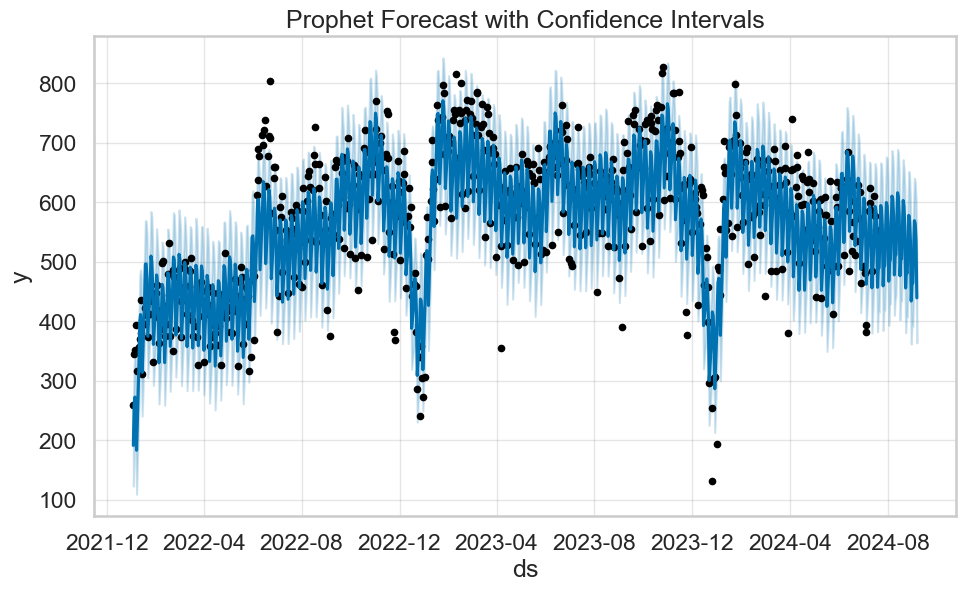

In [107]:

from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

# Plot the forecast
fig = model.plot(forecast)
plt.title("Prophet Forecast with Confidence Intervals")
plt.show()

/Users/martinguzman/environments/myenv-py311/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/martinguzman/environments/myenv-py311/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/martinguzman/environments/myenv-py311/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

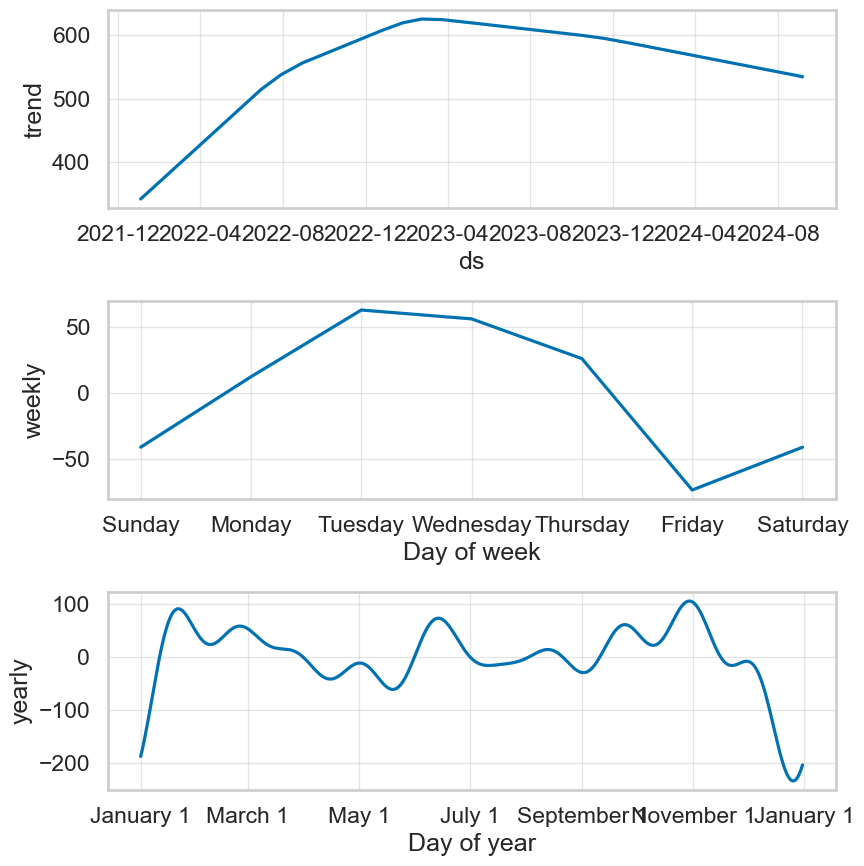

In [113]:
# Plot forecast components (trend, weekly, yearly seasonality, etc.)
fig_components = model.plot_components(forecast)

# Show the components plot
plt.show()

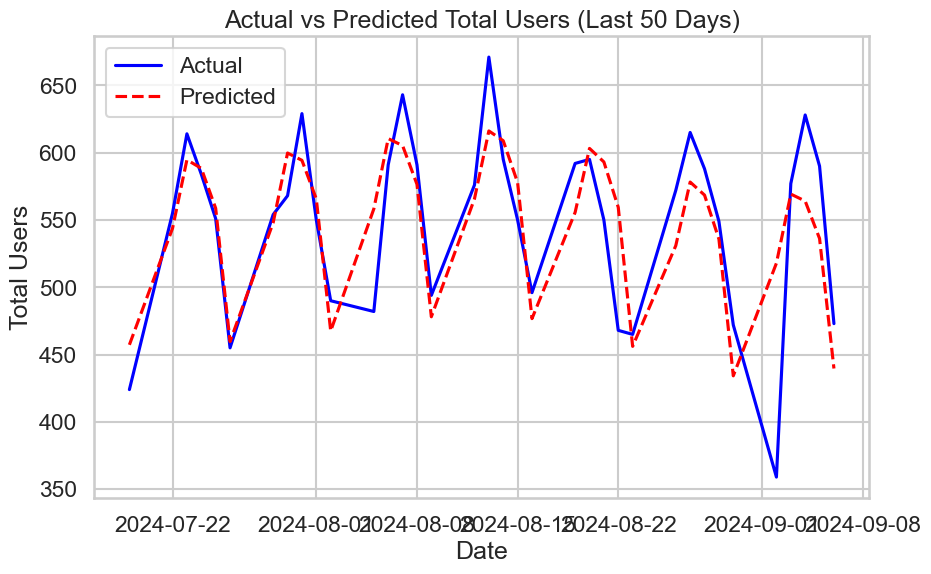

In [114]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(predicted_vs_actual['ds'], predicted_vs_actual['y'], label='Actual', color='blue')
plt.plot(predicted_vs_actual['ds'], predicted_vs_actual['yhat'], label='Predicted', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Total Users')
plt.title('Actual vs Predicted Total Users (Last 50 Days)')
plt.legend()
plt.show()

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and MSE
mae = mean_absolute_error(predicted_vs_actual['y'], predicted_vs_actual['yhat'])
mse = mean_squared_error(predicted_vs_actual['y'], predicted_vs_actual['yhat'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 31.52877522563835
Mean Squared Error (MSE): 1870.8407601272095


In [110]:
from prophet.diagnostics import cross_validation

# Perform cross-validation with an initial training period of 365 days,
# making predictions every 30 days, with a prediction horizon of 200 days
df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='200 days')

# Check the cross-validated predictions
df_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/13 [00:00<?, ?it/s]14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:00<00:00, 14.44it/s]14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:00<00:00, 15.38it/s]14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
14:57:36 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:00<00:00, 15.31it/s]14:57:36 - cmdstanpy - INFO - Chain [1] st

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-06,345.144157,280.426094,403.149897,505,2023-01-05
1,2023-01-09,453.010788,393.173980,516.387324,602,2023-01-05
2,2023-01-10,518.443918,454.896029,583.236832,667,2023-01-05
3,2023-01-11,529.205585,465.839642,589.133771,704,2023-01-05
4,2023-01-12,507.927304,451.745769,566.597303,623,2023-01-05


In [111]:
from prophet.diagnostics import performance_metrics

# Calculate the performance metrics for each horizon
df_p = performance_metrics(df_cv)

# Preview the performance metrics
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,8424.656967,91.785930,73.218862,0.118683,0.092724,0.118497,0.554354
1,21 days,8222.535870,90.678200,72.448535,0.113517,0.096871,0.115069,0.553754
2,22 days,8443.124685,91.886477,73.538966,0.114275,0.101825,0.116149,0.542943
3,23 days,8743.822277,93.508408,75.565149,0.118075,0.103378,0.119458,0.527027
4,24 days,9161.021782,95.713227,76.759855,0.128762,0.105066,0.124023,0.524324


/Users/martinguzman/environments/myenv-py311/lib/python3.11/site-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/Users/martinguzman/environments/myenv-py311/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



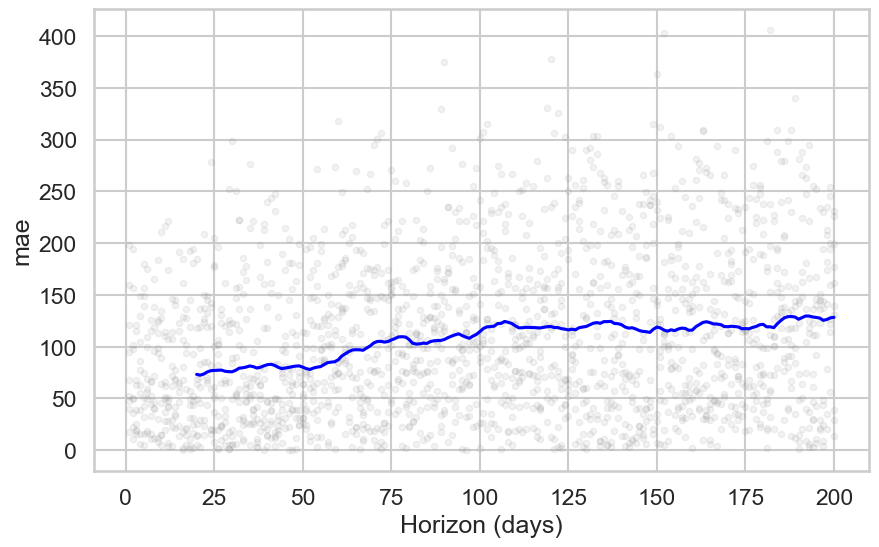

In [112]:
from prophet.plot import plot_cross_validation_metric

# Plot the Mean Absolute Error over different horizons
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()